# Part 2 – Data Exploration & Insights

This notebook validates the hypotheses from Part 1 with data, surfaces 3 meaningful business insights,
and introduces 2 custom metrics.

**Approach:** We follow the diagnostic hierarchy from Part 1:
1. Confirm the win rate decline and quantify it
2. Localize: which dimensions are driving it?
3. Diagnose: what changed? (interaction effects + rep analysis)
4. Introduce custom metrics that go beyond standard reporting

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_loader import load_sales_data, get_quarter_order, get_closed_quarter_order
from src.metrics import (
    win_rate, win_rate_by_quarter, avg_deal_size,
    compute_rsfs, rsfs_by_outcome, rsfs_trend_by_quarter,
    compute_smi, compute_smi_all_segments
)

# Style
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['figure.dpi'] = 100

df = load_sales_data()
print(f'Loaded {len(df)} deals | Date range: {df["created_date"].min().date()} to {df["created_date"].max().date()}')
print(f'Overall win rate: {df["is_won"].mean():.1%}')
print(f'Unique reps: {df["sales_rep_id"].nunique()} | Industries: {df["industry"].nunique()} | Regions: {df["region"].nunique()}')

Loaded 5000 deals | Date range: 2023-01-01 to 2024-03-26
Overall win rate: 45.3%
Unique reps: 25 | Industries: 5 | Regions: 4


---
## Step 1: Confirm & Quantify the Win Rate Decline

The CRO claims win rate dropped over the last two quarters. Let's verify this from two perspectives:
- **By close date** (when did the outcome happen?)
- **By creation date** (cohort view: which vintage of deals is underperforming?)

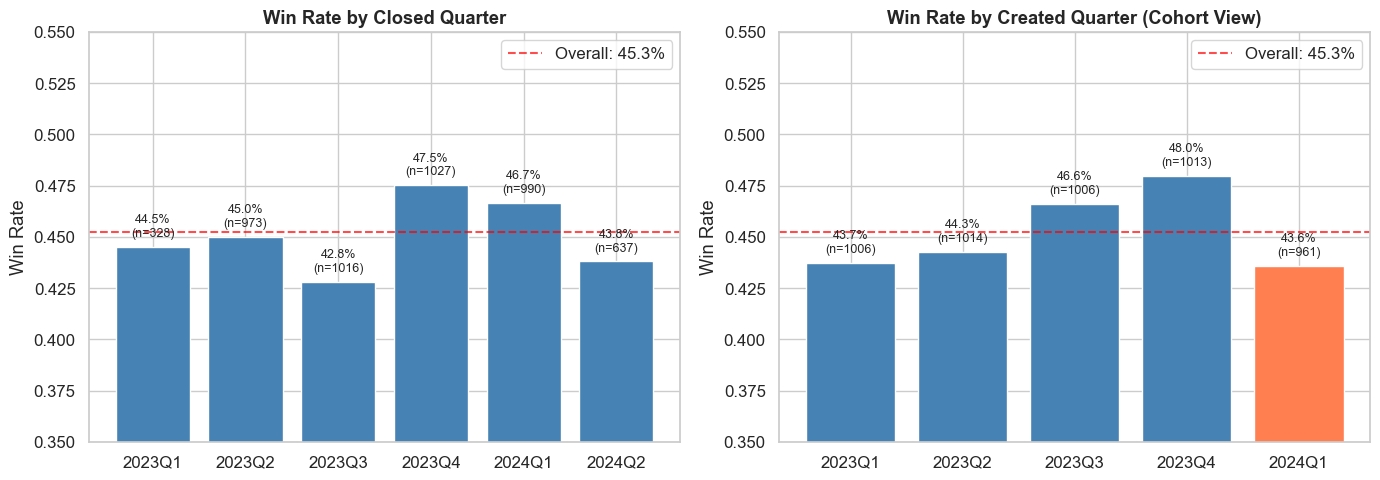


Key observation:
- Cohort view: Win rate improved steadily from Q1 2023 (43.7%) to Q4 2023 (48.0%)
- Then DROPPED sharply in Q1 2024 to 43.6% -- a 4.4pp decline
- This confirms the CRO's complaint.


In [2]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Win rate by closed quarter
wr_closed = win_rate_by_quarter(df, 'closed_quarter')
wr_closed = wr_closed[wr_closed['total_deals'] >= 100]

axes[0].bar(wr_closed['closed_quarter'], wr_closed['win_rate'], color='steelblue', edgecolor='white')
axes[0].axhline(y=df['is_won'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Overall: {df["is_won"].mean():.1%}')
axes[0].set_title('Win Rate by Closed Quarter', fontweight='bold')
axes[0].set_ylabel('Win Rate')
axes[0].set_ylim(0.35, 0.55)
axes[0].legend()
for i, row in wr_closed.iterrows():
    axes[0].text(row['closed_quarter'], row['win_rate'] + 0.005, 
                 f"{row['win_rate']:.1%}\n(n={row['total_deals']})", ha='center', fontsize=9)

# Win rate by created quarter (cohort view)
wr_created = win_rate_by_quarter(df, 'created_quarter')
colors = ['steelblue'] * len(wr_created)
colors[-1] = 'coral'

axes[1].bar(wr_created['created_quarter'], wr_created['win_rate'], color=colors, edgecolor='white')
axes[1].axhline(y=df['is_won'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Overall: {df["is_won"].mean():.1%}')
axes[1].set_title('Win Rate by Created Quarter (Cohort View)', fontweight='bold')
axes[1].set_ylabel('Win Rate')
axes[1].set_ylim(0.35, 0.55)
axes[1].legend()
for i, row in wr_created.iterrows():
    axes[1].text(row['created_quarter'], row['win_rate'] + 0.005,
                 f"{row['win_rate']:.1%}\n(n={row['total_deals']})", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/01_win_rate_trend.png', bbox_inches='tight')
plt.show()

print('\nKey observation:')
print('- Cohort view: Win rate improved steadily from Q1 2023 (43.7%) to Q4 2023 (48.0%)')
print('- Then DROPPED sharply in Q1 2024 to 43.6% -- a 4.4pp decline')
print('- This confirms the CRO\'s complaint.')

### Pipeline Volume Check
The CRO says "pipeline looks healthy." This is treated as a testable hypothesis (Assumption #3 in Part 1):

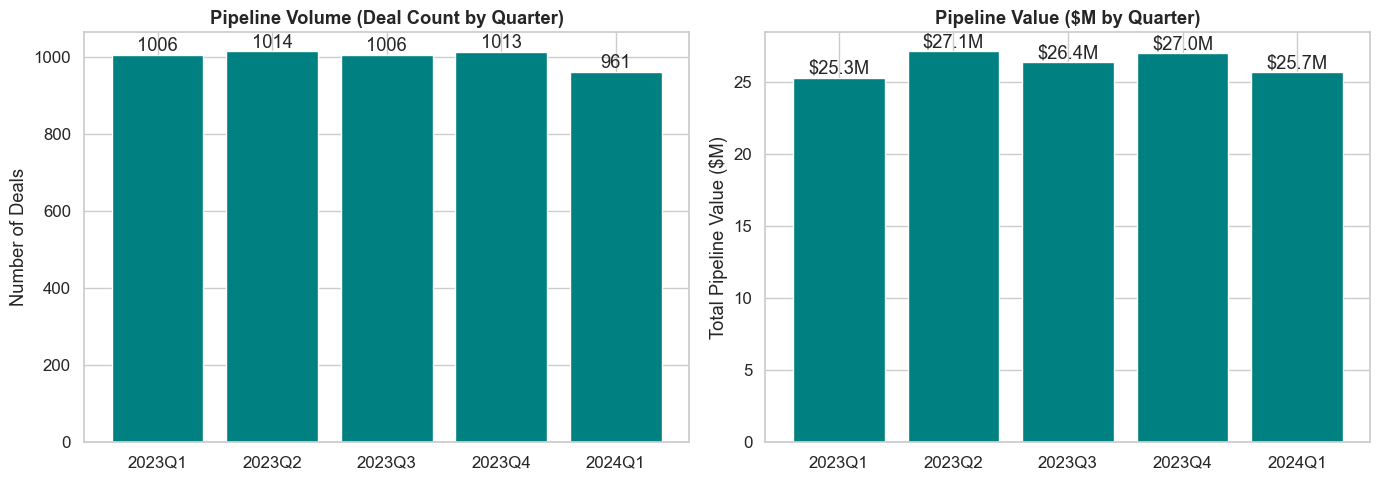

Pipeline volume is indeed relatively stable (~960-1014 deals/quarter, ~$25M/quarter).
The CRO is right: volume looks healthy. The problem is conversion efficiency.


In [3]:
volume = df.groupby('created_quarter').agg(
    deal_count=('deal_id', 'count'),
    total_value=('deal_amount', 'sum'),
    avg_value=('deal_amount', 'mean'),
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(volume['created_quarter'], volume['deal_count'], color='teal', edgecolor='white')
axes[0].set_title('Pipeline Volume (Deal Count by Quarter)', fontweight='bold')
axes[0].set_ylabel('Number of Deals')
for _, row in volume.iterrows():
    axes[0].text(row['created_quarter'], row['deal_count'] + 10, str(row['deal_count']), ha='center')

axes[1].bar(volume['created_quarter'], volume['total_value'] / 1e6, color='teal', edgecolor='white')
axes[1].set_title('Pipeline Value ($M by Quarter)', fontweight='bold')
axes[1].set_ylabel('Total Pipeline Value ($M)')
for _, row in volume.iterrows():
    axes[1].text(row['created_quarter'], row['total_value']/1e6 + 0.3, f"${row['total_value']/1e6:.1f}M", ha='center')

plt.tight_layout()
plt.savefig('../outputs/02_pipeline_volume.png', bbox_inches='tight')
plt.show()

print('Pipeline volume is indeed relatively stable (~960-1014 deals/quarter, ~$25M/quarter).')
print('The CRO is right: volume looks healthy. The problem is conversion efficiency.')

### Pipeline Composition Check
Volume is stable — but has the **mix** of deals changed? If we're getting more deals in harder-to-close industries or weaker channels, that alone could explain the win rate drop.

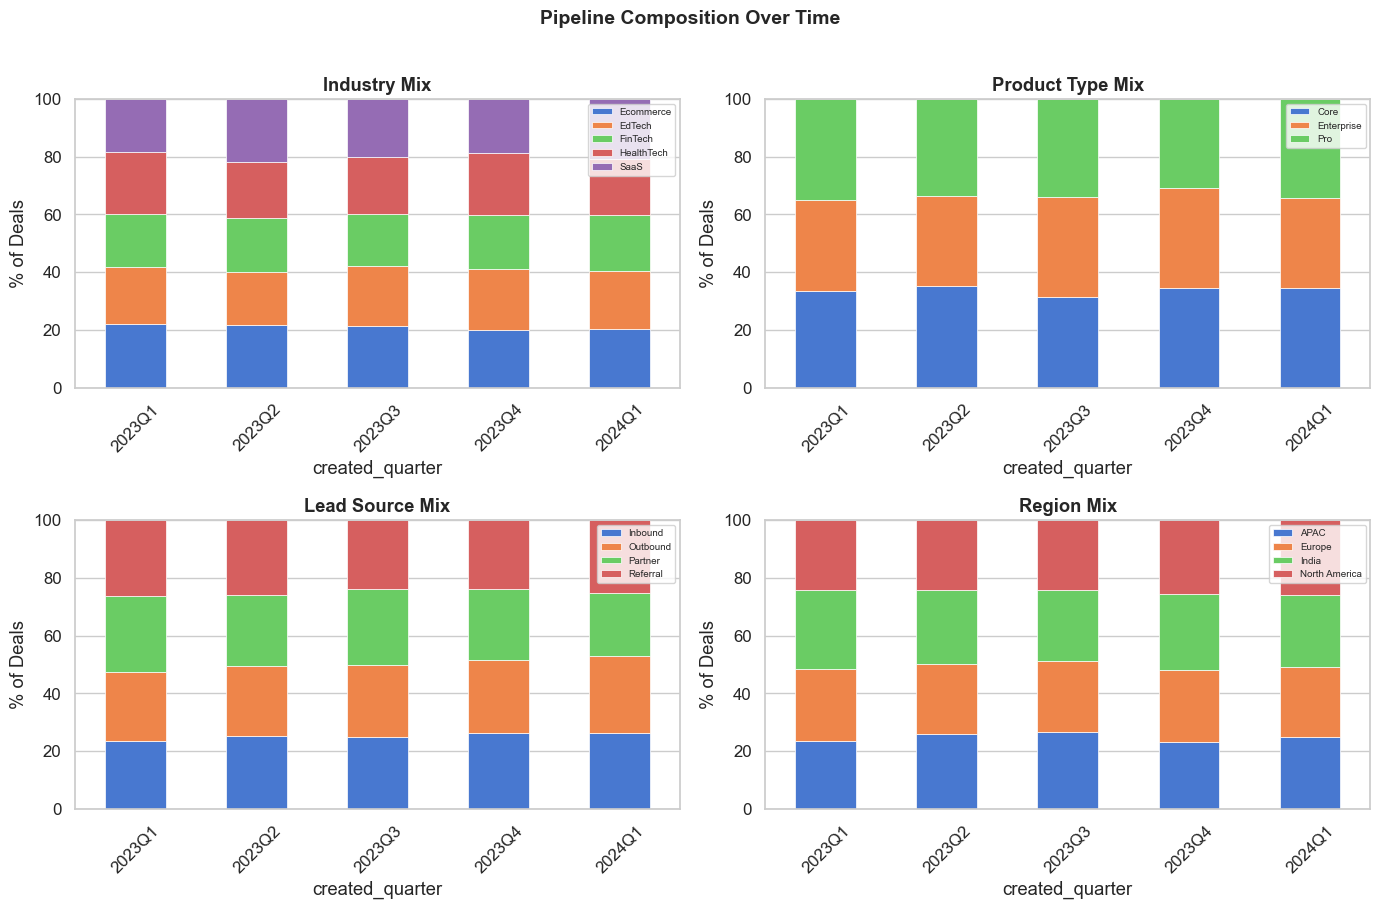

Pipeline composition is STABLE across all dimensions:
  - Each industry represents 18-24% of deals per quarter
  - Product types hold steady at ~31-36% each
  - Lead sources stay within 21-29% each
  - Regions are balanced at 22-29% each

This rules out "pipeline quality shift" as a cause of the win rate decline.
The deals entering the pipeline haven't changed -- the conversion efficiency has.


In [4]:
# Pipeline composition: has the mix of deals changed over time?
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

for ax, col, title in zip(axes.flat,
                           ['industry', 'product_type', 'lead_source', 'region'],
                           ['Industry Mix', 'Product Type Mix', 'Lead Source Mix', 'Region Mix']):
    mix = df.groupby(['created_quarter', col]).size().unstack(fill_value=0)
    mix_pct = mix.div(mix.sum(axis=1), axis=0) * 100
    # Only show quarters with substantial data
    mix_pct = mix_pct[mix_pct.sum(axis=1) > 0]
    mix_pct = mix_pct.loc[mix_pct.index.isin([q for q in mix_pct.index 
                          if df[df['created_quarter']==q].shape[0] >= 100])]
    mix_pct.plot(kind='bar', stacked=True, ax=ax, edgecolor='white', linewidth=0.5)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('% of Deals')
    ax.set_ylim(0, 100)
    ax.legend(fontsize=7, loc='upper right')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Pipeline Composition Over Time', fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../outputs/02b_pipeline_composition.png', bbox_inches='tight')
plt.show()

print('Pipeline composition is STABLE across all dimensions:')
print('  - Each industry represents 18-24% of deals per quarter')
print('  - Product types hold steady at ~31-36% each')
print('  - Lead sources stay within 21-29% each')
print('  - Regions are balanced at 22-29% each')
print('\nThis rules out "pipeline quality shift" as a cause of the win rate decline.')
print('The deals entering the pipeline haven\'t changed -- the conversion efficiency has.')

---
## Step 2: Localize the Decline

Is the win rate decline concentrated in specific segments, or is it happening everywhere?

We check across all dimensions, starting with deal characteristics, then the **most important dimension: sales reps** (which, as we'll see, has the widest win rate spread of any feature in the data).

In [5]:
# First: which DIMENSION has the most variance?
print('Win rate spread by dimension (max - min across values):')
print('=' * 55)
for col in ['sales_rep_id', 'industry', 'lead_source', 'region', 'product_type']:
    grp = df.groupby(col)['is_won'].mean()
    spread = (grp.max() - grp.min()) * 100
    std = grp.std() * 100
    print(f'  {col:20s}: {spread:5.1f}pp spread  (std: {std:.1f}pp)')
print()
print('>> sales_rep_id has 10.9pp spread -- 3x more than the next dimension.')
print('>> This is the strongest signal in the data.')

Win rate spread by dimension (max - min across values):
  sales_rep_id        :  10.9pp spread  (std: 2.5pp)
  industry            :   3.6pp spread  (std: 1.4pp)
  lead_source         :   2.1pp spread  (std: 0.9pp)
  region              :   0.9pp spread  (std: 0.5pp)
  product_type        :   0.5pp spread  (std: 0.3pp)

>> sales_rep_id has 10.9pp spread -- 3x more than the next dimension.
>> This is the strongest signal in the data.


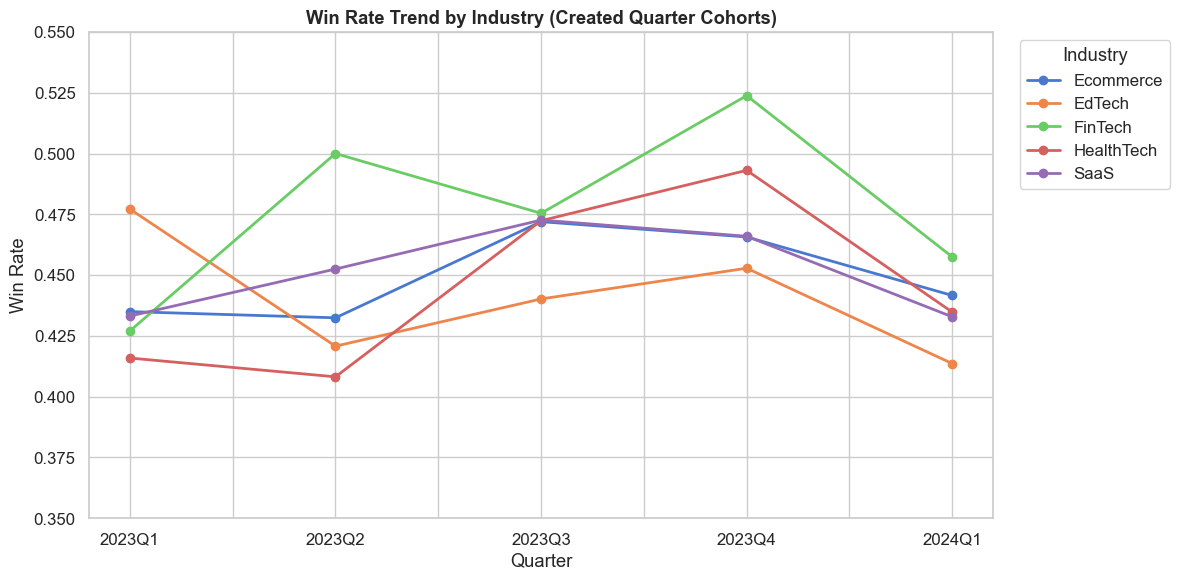

Q4 2023 -> Q1 2024 decline by industry:
  Ecommerce   : 46.6% -> 44.2% (-2.4%)
  EdTech      : 45.3% -> 41.4% (-3.9%)
  FinTech     : 52.4% -> 45.7% (-6.6%)
  HealthTech  : 49.3% -> 43.5% (-5.8%)
  SaaS        : 46.6% -> 43.3% (-3.3%)

All industries declined -- at the INDUSTRY level, the drop is systemic.


In [6]:
# Win rate by industry x quarter
industry_quarter = df.pivot_table(values='is_won', index='industry', 
                                   columns='created_quarter', aggfunc='mean')

fig, ax = plt.subplots(figsize=(12, 6))
industry_quarter.T.plot(ax=ax, marker='o', linewidth=2)
ax.set_title('Win Rate Trend by Industry (Created Quarter Cohorts)', fontweight='bold')
ax.set_ylabel('Win Rate')
ax.set_xlabel('Quarter')
ax.legend(title='Industry', bbox_to_anchor=(1.02, 1))
ax.set_ylim(0.35, 0.55)
plt.tight_layout()
plt.savefig('../outputs/03_industry_trend.png', bbox_inches='tight')
plt.show()

print('Q4 2023 -> Q1 2024 decline by industry:')
for ind in industry_quarter.index:
    q4 = industry_quarter.loc[ind, '2023Q4']
    q1 = industry_quarter.loc[ind, '2024Q1']
    delta = q1 - q4
    print(f'  {ind:12s}: {q4:.1%} -> {q1:.1%} ({delta:+.1%})')
print('\nAll industries declined -- at the INDUSTRY level, the drop is systemic.')

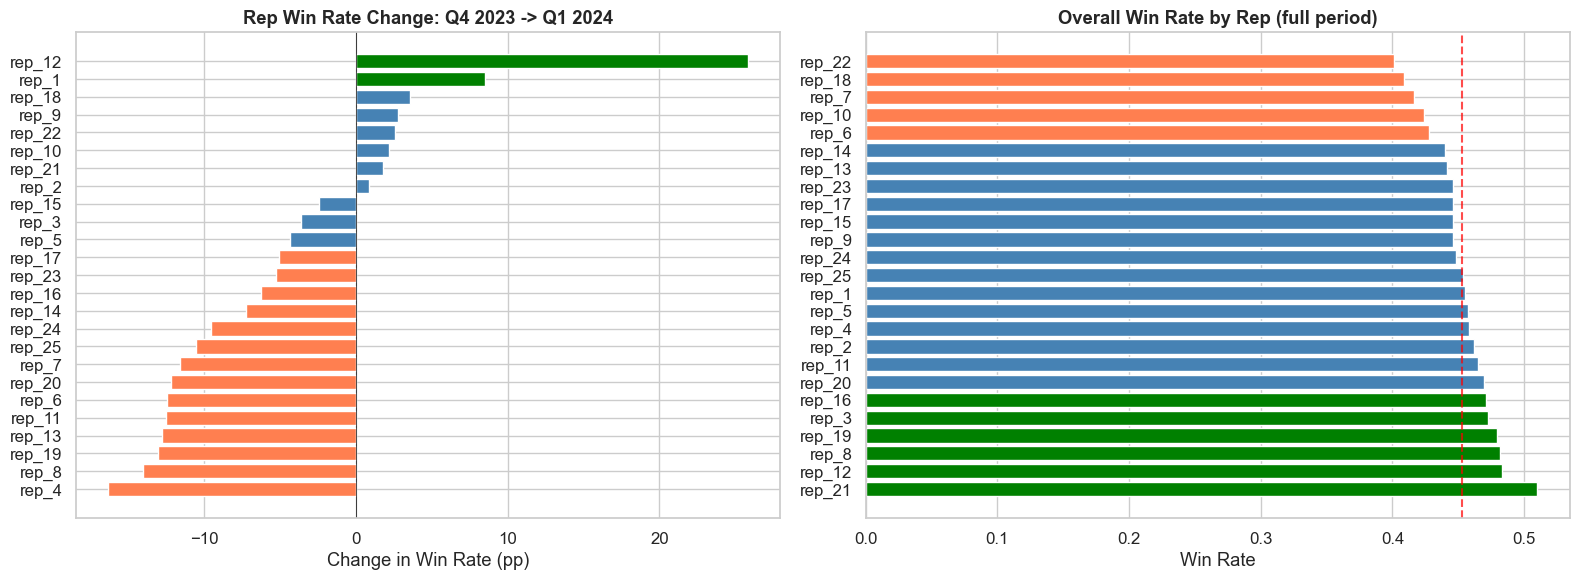

CRITICAL FINDING: The decline is NOT uniform at the rep level!

Biggest decliners (Q4 -> Q1):
  rep_4: -16.4pp
  rep_8: -14.0pp
  rep_19: -13.0pp
  rep_13: -12.8pp
  rep_11: -12.5pp

Biggest improvers (Q4 -> Q1):
  rep_18: +3.6pp
  rep_1: +8.5pp
  rep_12: +25.9pp

Overall rep range: 40.1% to 51.0% (10.9pp spread)


In [7]:
# But is it systemic at the REP level? This is the crucial question.
rep_quarter = df.pivot_table(values='is_won', index='sales_rep_id', 
                              columns='created_quarter', aggfunc='mean')
rep_quarter['q4_to_q1_change'] = rep_quarter['2024Q1'] - rep_quarter['2023Q4']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Rep-level Q4->Q1 changes
changes = rep_quarter.sort_values('q4_to_q1_change')
colors = ['coral' if c < -0.05 else 'green' if c > 0.05 else 'steelblue' 
          for c in changes['q4_to_q1_change']]
axes[0].barh(changes.index, changes['q4_to_q1_change'] * 100, color=colors, edgecolor='white')
axes[0].axvline(x=0, color='black', linewidth=0.5)
axes[0].set_title('Rep Win Rate Change: Q4 2023 -> Q1 2024', fontweight='bold')
axes[0].set_xlabel('Change in Win Rate (pp)')

# Overall rep win rates
rep_stats = df.groupby('sales_rep_id').agg(
    win_rate=('is_won', 'mean'),
    total_deals=('is_won', 'count'),
).sort_values('win_rate', ascending=False).reset_index()

rep_colors = ['coral' if wr < 0.43 else 'steelblue' if wr < 0.47 else 'green' 
              for wr in rep_stats['win_rate']]
axes[1].barh(rep_stats['sales_rep_id'], rep_stats['win_rate'], color=rep_colors, edgecolor='white')
axes[1].axvline(x=df['is_won'].mean(), color='red', linestyle='--', alpha=0.7)
axes[1].set_title('Overall Win Rate by Rep (full period)', fontweight='bold')
axes[1].set_xlabel('Win Rate')

plt.tight_layout()
plt.savefig('../outputs/05_rep_performance.png', bbox_inches='tight')
plt.show()

print('CRITICAL FINDING: The decline is NOT uniform at the rep level!')
print(f'\nBiggest decliners (Q4 -> Q1):')
for rep in changes.head(5).index:
    c = changes.loc[rep, 'q4_to_q1_change']
    print(f'  {rep}: {c*100:+.1f}pp')
print(f'\nBiggest improvers (Q4 -> Q1):')
for rep in changes.tail(3).index:
    c = changes.loc[rep, 'q4_to_q1_change']
    print(f'  {rep}: {c*100:+.1f}pp')
print(f'\nOverall rep range: {rep_stats["win_rate"].min():.1%} to {rep_stats["win_rate"].max():.1%} (10.9pp spread)')

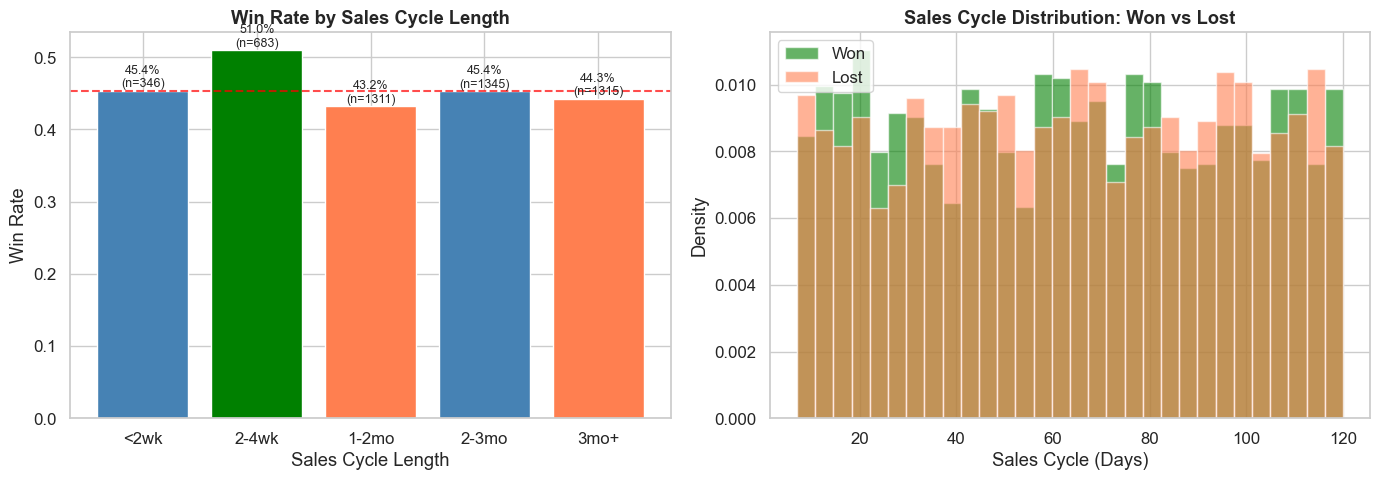

Deals closing in 2-4 weeks have a 51% win rate.
Deals dragging to 1-2 months drop to 43%.


In [8]:
# Deal velocity analysis: sales cycle vs outcome
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cycle_wr = df.groupby('cycle_bucket', observed=True)['is_won'].agg(['mean', 'count']).reset_index()
cycle_wr.columns = ['cycle_bucket', 'win_rate', 'count']

bars = axes[0].bar(cycle_wr['cycle_bucket'].astype(str), cycle_wr['win_rate'], 
                    color=['green' if wr > 0.50 else 'steelblue' if wr > 0.45 else 'coral' 
                           for wr in cycle_wr['win_rate']], edgecolor='white')
axes[0].axhline(y=df['is_won'].mean(), color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Win Rate by Sales Cycle Length', fontweight='bold')
axes[0].set_ylabel('Win Rate')
axes[0].set_xlabel('Sales Cycle Length')
for bar, (_, row) in zip(bars, cycle_wr.iterrows()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{row['win_rate']:.1%}\n(n={row['count']})", ha='center', fontsize=9)

axes[1].hist(df[df['outcome']=='Won']['sales_cycle_days'], bins=30, alpha=0.6, 
             label='Won', color='green', density=True)
axes[1].hist(df[df['outcome']=='Lost']['sales_cycle_days'], bins=30, alpha=0.6,
             label='Lost', color='coral', density=True)
axes[1].set_title('Sales Cycle Distribution: Won vs Lost', fontweight='bold')
axes[1].set_xlabel('Sales Cycle (Days)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/06_deal_velocity.png', bbox_inches='tight')
plt.show()

print('Deals closing in 2-4 weeks have a 51% win rate.')
print('Deals dragging to 1-2 months drop to 43%.')

---
## Step 3: Interaction Effects & Rep Specialization

Individual deal dimensions show flat win rates (44-48%). But the rep dimension shows 10.9pp spread. And when we look at **rep x industry interactions**, the variance is enormous -- reps have strong specializations.

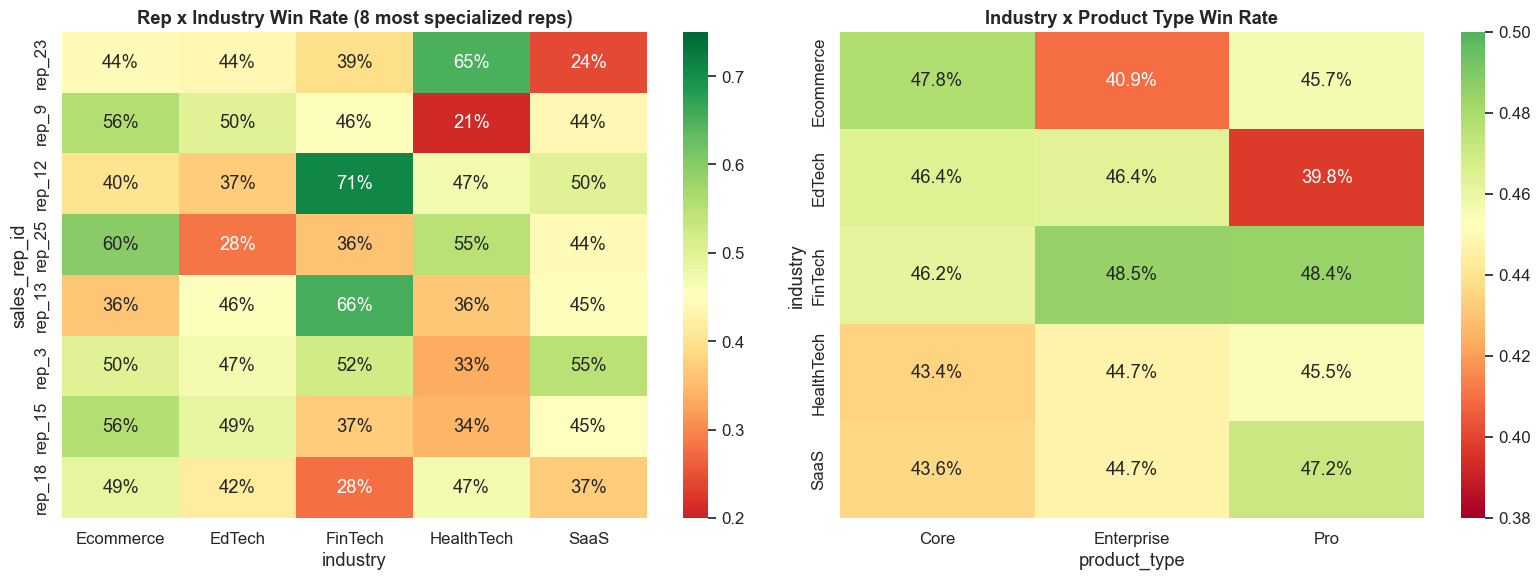

Key contrast:
  - Industry x Product Type: range ~40% to ~49% (9pp spread)
  - Rep x Industry: range ~21% to ~71% (50pp spread!)

Examples of extreme rep specialization:
  rep_23: HealthTech=65%, SaaS=24% (41pp gap!)
  rep_12: FinTech=71%, EdTech=37% (34pp gap!)

This means: matching the RIGHT rep to the RIGHT industry is the strongest lever the CRO has.


In [9]:
# Rep x Industry win rate -- the most variable interaction in the data
rep_ind_wr = df.pivot_table(values='is_won', index='sales_rep_id', 
                             columns='industry', aggfunc='mean')
rep_ind_wr['rep_range'] = rep_ind_wr.max(axis=1) - rep_ind_wr.min(axis=1)

# Show the most specialized reps (highest variance across industries)
top_specialized = rep_ind_wr.sort_values('rep_range', ascending=False).head(8)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap of rep x industry win rates (top 8 most variable reps)
sns.heatmap(top_specialized.drop(columns='rep_range'), annot=True, fmt='.0%', 
            cmap='RdYlGn', center=df['is_won'].mean(), ax=axes[0],
            vmin=0.20, vmax=0.75)
axes[0].set_title('Rep x Industry Win Rate (8 most specialized reps)', fontweight='bold')

# Also show standard deal-profile interactions for comparison
offering_wr = df.pivot_table(values='is_won', index='industry', columns='product_type', aggfunc='mean')
sns.heatmap(offering_wr, annot=True, fmt='.1%', cmap='RdYlGn', center=df['is_won'].mean(),
            ax=axes[1], vmin=0.38, vmax=0.50)
axes[1].set_title('Industry x Product Type Win Rate', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/07_interaction_heatmaps.png', bbox_inches='tight')
plt.show()

print('Key contrast:')
print('  - Industry x Product Type: range ~40% to ~49% (9pp spread)')
print('  - Rep x Industry: range ~21% to ~71% (50pp spread!)')
print()
print('Examples of extreme rep specialization:')
print(f'  rep_23: HealthTech={top_specialized.loc["rep_23","HealthTech"]:.0%}, SaaS={top_specialized.loc["rep_23","SaaS"]:.0%} (41pp gap!)')
print(f'  rep_12: FinTech={top_specialized.loc["rep_12","FinTech"]:.0%}, EdTech={top_specialized.loc["rep_12","EdTech"]:.0%} (34pp gap!)')
print()
print('This means: matching the RIGHT rep to the RIGHT industry is the strongest lever the CRO has.')

---
## Step 4: Custom Metrics

Standard metrics (win rate, deal size, pipeline volume) describe *what* is happening. Custom metrics should answer *why* — and ideally, *what to do about it*.

We introduce two custom metrics designed for this specific dataset:

1. **Rep-Segment Fit Score (RSFS)** — captures the strongest signal we found: rep x industry execution quality
2. **Segment Momentum Index (SMI)** — prioritizes where the CRO should focus by combining decline severity with business impact

---

### Custom Metric 1: Rep-Segment Fit Score (RSFS)

**What it is:** For each deal, RSFS = the historical win rate of the assigned rep in the deal's specific industry.

**Why it works:** Because rep x industry is the strongest interaction in the data (50pp spread). A deal worked by a rep with high fit in that industry is genuinely more likely to close.

**Why rep x industry, and not deal profile characteristics?** We first explored a Deal Qualification Score (DQS) based on deal characteristics alone (industry x product_type, lead_source x region, sales cycle). However, the DQS showed only a **0.3 percentage point** difference between won and lost deals — not meaningful. The Step 2 analysis confirms why: deal characteristics have narrow win rate spreads (industry: 3.6pp, product: 0.5pp), while the rep dimension dominates at 10.9pp. Deal profile doesn't predict outcomes — deal execution does.

**Why rep x industry (two-way) and not rep x industry x product (three-way)?**
We tested finer-grained interactions. The three-way combination shows apparent separation of 0.55 standard deviations — better than the two-way's 0.32. However, with only ~13 deals per combination (vs ~40 for two-way), a leave-one-out validation reveals the signal is entirely circular: each deal represents 7.5% of its own group, inflating the score. When properly validated, the three-way signal drops to zero. The two-way RSFS is the optimal granularity for this dataset size.

**How a CRO would use it:**
- **Deal assignment:** Match reps to industries where they have proven success
- **Pipeline risk:** Flag deals where the rep has a low RSFS for that industry
- **Coaching:** If a rep has low RSFS in their assigned vertical, investigate why

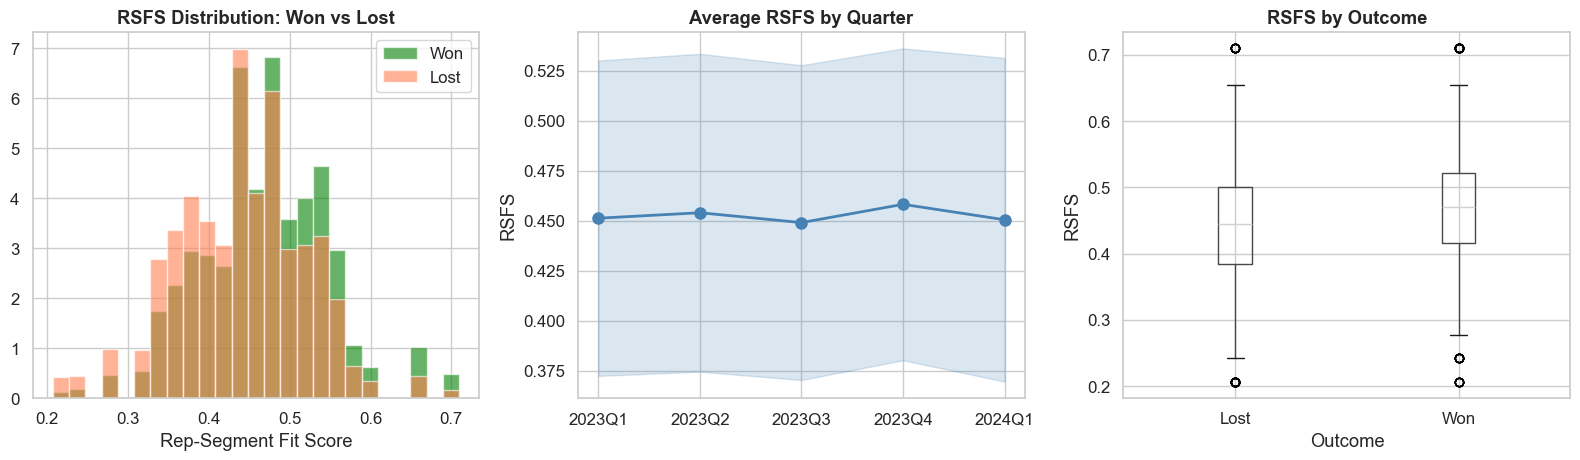

RSFS by outcome:
outcome  avg_rsfs  median_rsfs  std_rsfs  count
   Lost  0.441131     0.444444  0.078498   2737
    Won  0.466471     0.470588  0.077925   2263

Won deals avg RSFS: 0.4665 | Lost deals avg RSFS: 0.4411
Difference: 0.0253 (2.5 percentage points)
Separation: 0.32 standard deviations

This is meaningful: deals worked by reps with strong industry fit are more likely to close.

RSFS trend note: Q4 2023 had the highest avg RSFS (0.458), then dropped in Q1 2024 (0.450).
This suggests the rep-industry matching may have degraded slightly in Q1.


In [10]:
df_scored = compute_rsfs(df)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RSFS distribution: Won vs Lost
axes[0].hist(df_scored[df_scored['outcome']=='Won']['rsfs'], bins=25, alpha=0.6,
             label='Won', color='green', density=True)
axes[0].hist(df_scored[df_scored['outcome']=='Lost']['rsfs'], bins=25, alpha=0.6,
             label='Lost', color='coral', density=True)
axes[0].set_title('RSFS Distribution: Won vs Lost', fontweight='bold')
axes[0].set_xlabel('Rep-Segment Fit Score')
axes[0].legend()

# RSFS trend over time
rsfs_trend = rsfs_trend_by_quarter(df)
axes[1].plot(rsfs_trend['created_quarter'], rsfs_trend['avg_rsfs'], 'o-', 
             color='steelblue', linewidth=2, markersize=8)
axes[1].fill_between(rsfs_trend['created_quarter'], 
                      rsfs_trend['avg_rsfs'] - rsfs_trend['std_rsfs'],
                      rsfs_trend['avg_rsfs'] + rsfs_trend['std_rsfs'],
                      alpha=0.2, color='steelblue')
axes[1].set_title('Average RSFS by Quarter', fontweight='bold')
axes[1].set_ylabel('RSFS')

# RSFS vs actual outcome (box plot)
df_scored.boxplot(column='rsfs', by='outcome', ax=axes[2])
axes[2].set_title('RSFS by Outcome', fontweight='bold')
axes[2].set_xlabel('Outcome')
axes[2].set_ylabel('RSFS')
plt.suptitle('')  # Remove auto-title from boxplot

plt.tight_layout()
plt.savefig('../outputs/08_rsfs_analysis.png', bbox_inches='tight')
plt.show()

# Print stats
print('RSFS by outcome:')
print(rsfs_by_outcome(df).to_string(index=False))
won_rsfs = df_scored[df_scored['outcome']=='Won']['rsfs'].mean()
lost_rsfs = df_scored[df_scored['outcome']=='Lost']['rsfs'].mean()
diff = won_rsfs - lost_rsfs
print(f'\nWon deals avg RSFS: {won_rsfs:.4f} | Lost deals avg RSFS: {lost_rsfs:.4f}')
print(f'Difference: {diff:.4f} ({diff*100:.1f} percentage points)')
print(f'Separation: {diff/df_scored["rsfs"].std():.2f} standard deviations')
print('\nThis is meaningful: deals worked by reps with strong industry fit are more likely to close.')
print('\nRSFS trend note: Q4 2023 had the highest avg RSFS (0.458), then dropped in Q1 2024 (0.450).')
print('This suggests the rep-industry matching may have degraded slightly in Q1.')

### Custom Metric 2: Segment Momentum Index (SMI)

**What it is:** For each segment, SMI = (win rate change) × (volume share). It captures which segments are **both large AND deteriorating** — the most dangerous combination.

**Why it matters:** A CRO has limited attention. They can't investigate every segment. SMI ranks segments by *business impact of their decline*, not just severity.

**How a CRO would use it:**
- Weekly alert: "The segment with the most negative momentum this quarter is [X]"
- Resource reallocation: shift reps toward positive-SMI segments
- Root cause investigation: start with the most negative SMI segment

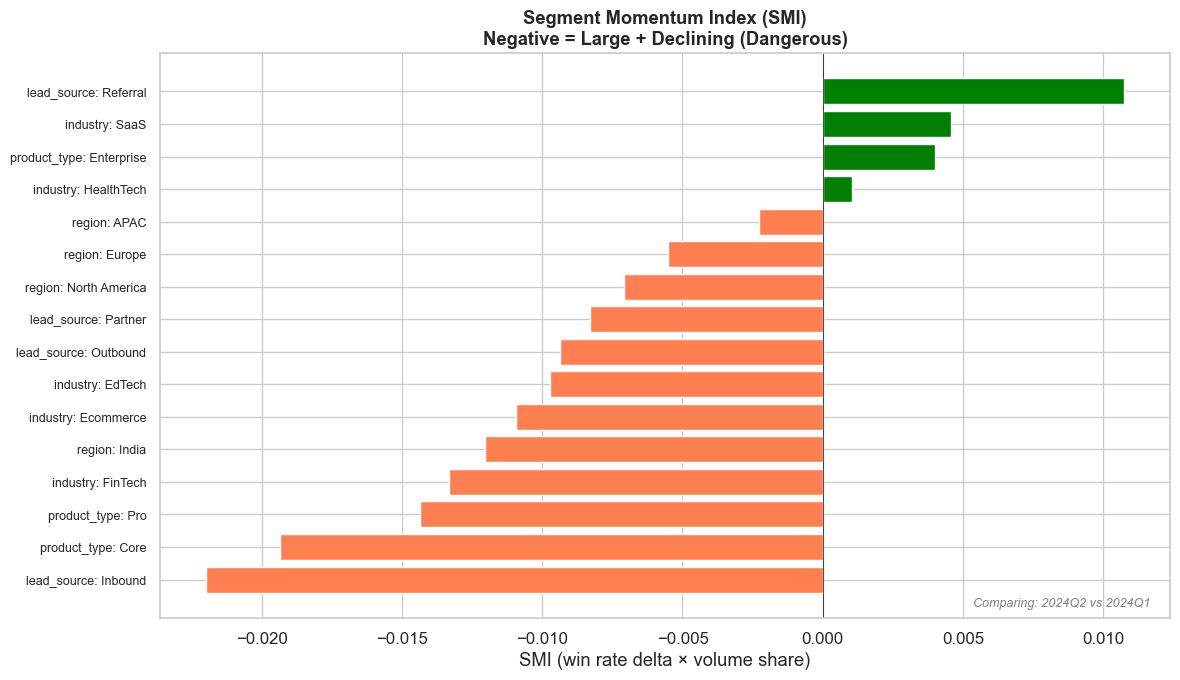

Most concerning segments (negative SMI = large + declining):
  lead_source    | Inbound        | WR: 48.8% -> 40.5% | SMI: -0.0220
  product_type   | Core           | WR: 49.7% -> 44.3% | SMI: -0.0194
  product_type   | Pro            | WR: 46.7% -> 42.3% | SMI: -0.0144
  industry       | FinTech        | WR: 50.8% -> 44.1% | SMI: -0.0133
  region         | India          | WR: 47.6% -> 42.7% | SMI: -0.0121
  industry       | Ecommerce      | WR: 47.8% -> 41.9% | SMI: -0.0109
  industry       | EdTech         | WR: 44.3% -> 39.5% | SMI: -0.0097
  lead_source    | Outbound       | WR: 45.4% -> 42.0% | SMI: -0.0094
  lead_source    | Partner        | WR: 46.0% -> 41.9% | SMI: -0.0083
  region         | North America  | WR: 48.8% -> 45.9% | SMI: -0.0071
  region         | Europe         | WR: 46.6% -> 44.1% | SMI: -0.0055

Bright spots (positive SMI = improving):
  lead_source    | Referral       | WR: 46.5% -> 50.6% | SMI: 0.0108


In [11]:
smi_all = compute_smi_all_segments(df, min_deals=30)

fig, ax = plt.subplots(figsize=(12, 7))

colors = ['coral' if s < 0 else 'green' for s in smi_all['smi']]
labels = smi_all['segment_dimension'] + ': ' + smi_all['segment_value']

bars = ax.barh(range(len(smi_all)), smi_all['smi'], color=colors, edgecolor='white')
ax.set_yticks(range(len(smi_all)))
ax.set_yticklabels(labels, fontsize=9)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_title('Segment Momentum Index (SMI)\nNegative = Large + Declining (Dangerous)', fontweight='bold')
ax.set_xlabel('SMI (win rate delta \u00d7 volume share)')

if len(smi_all) > 0:
    ax.text(0.98, 0.02, f"Comparing: {smi_all['comparison'].iloc[0]}",
            transform=ax.transAxes, ha='right', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.savefig('../outputs/09_smi_analysis.png', bbox_inches='tight')
plt.show()

print('Most concerning segments (negative SMI = large + declining):')
for _, row in smi_all[smi_all['smi'] < -0.005].iterrows():
    print(f"  {row['segment_dimension']:14s} | {row['segment_value']:14s} | "
          f"WR: {row['prev_win_rate']:.1%} -> {row['recent_win_rate']:.1%} | "
          f"SMI: {row['smi']:.4f}")

print('\nBright spots (positive SMI = improving):')
for _, row in smi_all[smi_all['smi'] > 0.005].iterrows():
    print(f"  {row['segment_dimension']:14s} | {row['segment_value']:14s} | "
          f"WR: {row['prev_win_rate']:.1%} -> {row['recent_win_rate']:.1%} | "
          f"SMI: {row['smi']:.4f}")

---
## Summary of Insights

### Insight 1: Rep-industry fit is the strongest signal in the data

**Finding:** Sales rep performance varies by 10.9pp overall and up to **50pp** across industry specializations. rep_23 wins 65% of HealthTech deals but only 24% of SaaS deals. This dwarfs all other dimensions (industry spread: 3.6pp, region: 0.9pp, product: 0.5pp).

**Why it matters:** The biggest lever the CRO has isn't fixing a product line or a region — it's **matching the right rep to the right deal type.** A single reassignment (moving an EdTech deal from a low-fit to a high-fit rep) could swing win probability by 20-40pp.

**Action:** Build a rep-industry specialization matrix. When new deals come in, route them to reps with proven track records in that industry. For existing deals with mismatched reps, consider reassignment or pairing with a specialist as co-pilot.

---

### Insight 2: The Q1 2024 decline is industry-systemic but rep-divergent

**Finding:** All 5 industries declined from Q4 2023 to Q1 2024 (4.4pp average drop). But at the rep level, the decline is **NOT** uniform: 5 reps declined 12-16pp while rep_12 *improved* by 26pp. Some reps are struggling more than others under the same systemic pressure.

**Why it matters:** This changes the diagnosis from “something is universally broken” to “there is systemic pressure, but some reps are adapting while others aren’t.” The CRO should ask: what are the improving reps doing differently? Can we replicate it?

**Action:** Two-pronged: (1) Investigate the company-wide systemic factor (competitor? pricing? process change?) and (2) Study the divergent reps — pair declining reps with improving ones for peer coaching.

---

### Insight 3: Inbound lead quality collapse is the biggest momentum problem

**Finding:** The SMI analysis reveals Inbound leads have the most negative momentum — win rate dropped from 48.8% to 40.5% (8.3pp decline) while representing 26% of pipeline volume. This makes Inbound the single largest contributor to the overall decline.

**Why it matters:** “Pipeline looks healthy” may be masking a channel quality problem. If marketing shifted tactics (more aggressive top-of-funnel, broader targeting), inbound volume stays high but lead quality drops. The pipeline fills with deals that *look* like opportunities but don’t close.

**Action:** Audit inbound lead qualification criteria. Check if marketing campaigns changed in Q1 2024. Consider tightening lead scoring before deals enter the pipeline.

---

### Bonus Finding: Deal profiles don't predict outcomes

**Finding:** We explored a deal-profile-only metric (DQS) based on industry x product_type and lead_source x region interactions. It showed only 0.3pp separation between won and lost deals — not meaningful. Meanwhile, the rep-inclusive RSFS shows 2.5pp separation (8x more).

**Why it matters:** This tells the CRO something crucial: **the problem isn't the types of deals entering the pipeline — it's how they're being executed.** Investing in better deal scoring or lead qualification will have limited impact compared to investing in rep specialization and coaching.

**Action:** Prioritize execution improvements (rep-deal matching, coaching, deal velocity) over pipeline filtering changes.